# Capstone Project ‐ Where to rent in Singapore?

# Setup

In [ ]:
#imports for use
import pandas as pd
import requests
import numpy as np

#import Beautiful Soup for web scrape
from bs4 import BeautifulSoup

#install necessary packages
get_ipython().system('conda install -c conda-forge geopy --yes')
get_ipython().system('conda install -c conda-forge folium=0.5.0 --yes')

#converting an address into latitude and longitude values
from geopy.geocoders import Nominatim 

#library to handle requests
import requests 

#matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

#import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

#map rendering library
import folium

#plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#additional mapping
from folium import plugins
from folium.plugins import HeatMap

# Scrape Urban Redevelopment Authority page using Beautiful Soup

In [2]:
#scrape Urban Redevelopment Authority page District Code and District Map of Singapore  
res = requests.get("https://www.ura.gov.sg/realEstateIIWeb/resources/misc/list_of_postal_districts.htm")

#use lxml HTML parser as recomeded by Beautiful Soup documentation
#parse HTML as a string
soup = BeautifulSoup(res.content,"lxml")

#grab first table only. page only contains one table
table = soup.find_all("table")[0]

#create dataframe as SGpost
SGpost = pd.read_html(str(table))[0]

# Cleaning

In [3]:
#cleaning SGpost

#table contains no table header information therefore drop first row as this is colum titles
SGpost = SGpost.drop([0])

#drop column 1 Postal Sector as this will not be used
SGpost = SGpost.drop(columns=[1])

#rename columns
SGpost.columns = ["Postal District", "General Location"]

#remove multiple values in General Location
SGpost['General Location'] = SGpost['General Location'].str.split(',').str[0]

#cast
SGpost["Postal District"] = SGpost["Postal District"].astype(int)
SGpost["Postal District"] = SGpost["Postal District"].astype(str)

In [4]:
#use geolocator to assign Postal District with latitude and longitude
#provide geolocator with app name
geolocator = Nominatim(user_agent="SGrental")

#create lists for lattitude and longittude
lat = []
long = []

#loop for each Postal District
for dist in SGpost["General Location"]:

    location = geolocator.geocode(dist +", Singapore")
    lat.append(location.latitude)
    long.append(location.longitude)

#insert the lists to main dataset    
SGpost["Latitude"] = lat
SGpost["Longitude"] = long

In [5]:
SGpost

,Postal District,General Location,Latitude,Longitude
1,1,Raffles Place,1.284408,103.851390
2,2,Anson,1.275815,103.846491
3,3,Queenstown,1.294623,103.806045
4,4,Telok Blangah,1.270586,103.809863
5,5,Pasir Panjang,1.276201,103.791476
6,6,High Street,1.290125,103.850106
7,7,Middle Road,1.298840,103.853757
8,8,Little India,1.307457,103.852572
9,9,Orchard,1.305272,103.832876
10,10,Ardmore,1.308830,103.830130


# A general map of Singapore

In [6]:
#a general map of Singapore

#use geopy to find latitude and longitude of Singapore
sgaddress = 'Singapore, Singapore'
sglocation = geolocator.geocode(sgaddress)
sglatitude = location.latitude
sglongitude = location.longitude

#zoom 12 selected 
map_SG = folium.Map(location=[sglatitude, sglongitude], zoom_start=12)

#add markers to map
for lat, lng, location in zip(SGpost['Latitude'], SGpost['Longitude'], SGpost['General Location']):
    label = '{}'.format(location)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_SG)  
    
map_SG

# Connect to data.gov.sg and retrieve rental data

In [7]:
#Contains information from { Rentals of Non-Landed Residential Buildings, Quarterly } accessed on { 17/11/2019 } from { https://data.gov.sg/) } 
#which is made available under the terms of the Singapore Open Data Licence version 1.0 { https://data.gov.sg/open-data-licence }

#connect url to data.gov.sg API
url = "https://data.gov.sg/api/action/datastore_search?resource_id=4384e22c-234f-4196-9df8-1941cd41c667&limit=1000&fields=project_name%2C%20postal_district%2C%2025th_percentile%2C%20median%2C%2075th_percentile"
data = requests.get(url).json()

SGrental = pd.DataFrame(data['result']['records'])

In [8]:
#rename columns
SGrental.columns = ["25th Percentile", "75th Percentile", "Median", "Postal District", "Project Name"]

SGrental = SGrental[["Postal District", "Project Name", "25th Percentile", "Median", "75th Percentile"]]

#set types
SGrental["25th Percentile"] = SGrental["25th Percentile"].astype(float)
SGrental["Median"] = SGrental["Median"].astype(float)
SGrental["75th Percentile"] = SGrental["75th Percentile"].astype(float)

In [9]:
SGrental

,Postal District,Project Name,25th Percentile,Median,75th Percentile
0,20,THOMSON VIEW CONDO,17.53,20.83,21.52
1,9,TIARA,32.14,34.71,37.82
2,15,TIERRA VUE,25.88,30.30,34.69
3,3,TIONG BAHRU ESTATE,32.66,37.95,45.48
4,14,TRE RESIDENCES,41.02,43.41,49.53
5,23,TREE HOUSE,26.17,27.50,28.07
6,12,TRELLIS TOWERS,28.99,34.85,39.22
7,20,TRESALVEO,27.85,32.69,37.50
8,12,TREVISTA,33.05,35.71,38.46
9,9,TRIBECA,39.84,45.83,54.17


# Initital exploration 

In [10]:
#intial exploration of data
SGrental.describe()

,25th Percentile,Median,75th Percentile
count,604.000000,604.000000,604.000000
mean,33.306523,35.974156,39.159603
std,9.515605,10.339549,11.378834
min,16.260000,17.200000,18.770000
25%,26.170000,28.167500,30.575000
50%,31.710000,34.065000,37.390000
75%,39.155000,43.157500,46.135000
max,67.010000,70.710000,76.550000


In [11]:
#create SGdata as mean rental rate of median within each postal code
SGdata = SGrental.groupby(["Postal District"], as_index=False).mean()

#cast Postal District to integer for easy sorting
SGdata["Postal District"] = SGdata["Postal District"].astype(int)

#sort
SGdata = SGdata.sort_values(["Postal District"])

#replace index
SGdata.set_index("Postal District", inplace=True)

#inner join SGdata and SGpost to give latitude and longitude for plotting
SGdata = pd.concat([SGdata, SGpost], axis=1, join='inner').reindex(SGdata.index)

#cleanup additional column from join
SGdata = SGdata.drop(columns=["Postal District"])

In [12]:
SGdata

,25th Percentile,Median,75th Percentile,General Location,Latitude,Longitude
Postal District,,,,,,
1,47.160000,51.352500,57.315833,Raffles Place,1.284408,103.851390
2,48.703333,52.924167,56.813333,Anson,1.275815,103.846491
3,39.040952,42.280000,46.495238,Queenstown,1.294623,103.806045
4,38.577500,41.421250,44.738125,Telok Blangah,1.270586,103.809863
5,31.870278,35.163056,37.979722,Pasir Panjang,1.276201,103.791476
6,24.730000,26.350000,30.990000,High Street,1.290125,103.850106
7,41.111250,44.205000,48.055000,Middle Road,1.298840,103.853757
8,36.598000,39.322000,43.096000,Little India,1.307457,103.852572
9,42.432083,45.807639,50.228472,Orchard,1.305272,103.832876


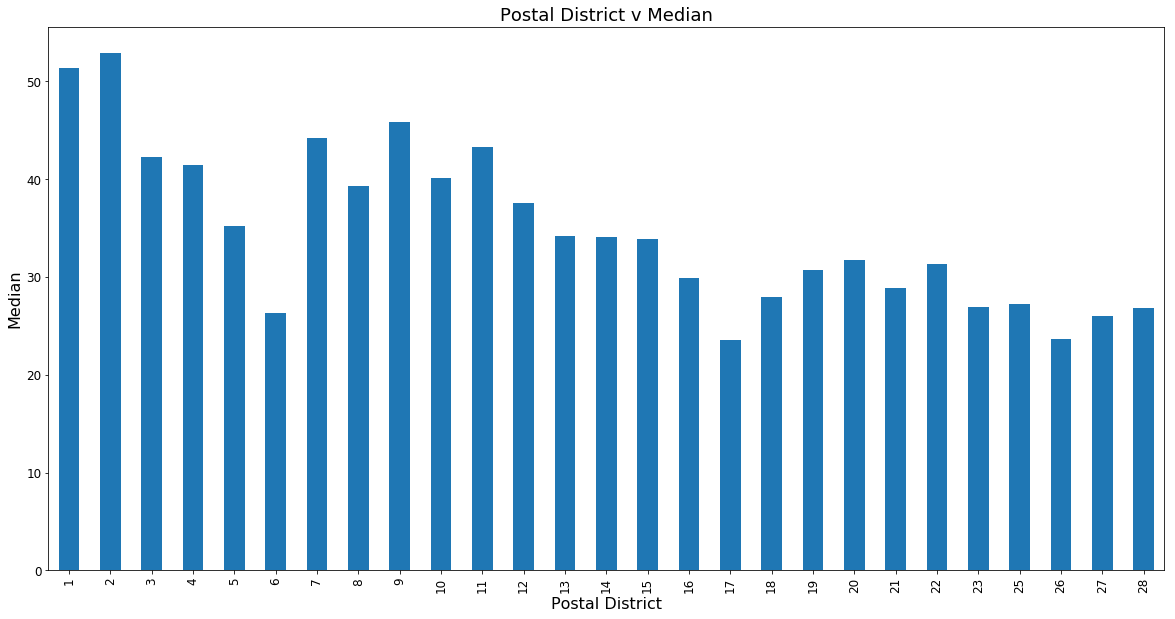

In [13]:
#graph Median rental rates for comparison
SGgraph = SGdata["Median"]

#plot bar
SGgraph.plot(kind="bar", figsize=(20,10), fontsize=12)

#formatting
plt.title('Postal District v Median', fontsize=18)
plt.xlabel('Postal District', fontsize=16)
plt.ylabel('Median', fontsize=16)
plt.show()

# Create bubble map of Singapore rent

In [14]:
#create base map zoom 12 selected 
base_map = folium.Map(location=[sglatitude, sglongitude], zoom_start=12)

#add circle marker to map using Median as radius
#multiply all radius for clarity and visual impact
for i in range(0,len(SGdata)):
   folium.Circle(
      location=[SGdata.iloc[i]['Latitude'], SGdata.iloc[i]['Longitude']],
      radius=SGdata.iloc[i]['Median']*50,
      color='crimson',
      fill=True,
      fill_color='crimson'
   ).add_to(base_map)

#add markers to map set radius of marker to 2 not to ditract from map view informaiton
for lat, lng, location in zip(SGpost['Latitude'], SGpost['Longitude'], SGpost['General Location']):
    label = '{}'.format(location)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(base_map)

#show map
base_map

# Foursqaure API use

In [15]:
#Foursquare required details
CLIENT_ID = 'S2YDPIQFORGXOCZHCHFOSBZ3S0ZQZSDWDVASWLKILS5LQ4M0' 
CLIENT_SECRET = 'TUHYBUMFK1BRDAH3PW1IAQVATDSFZB4JLHODA2UYN3VVW55R'
VERSION = '20180605'

In [16]:
#function to select 2000 venues within 2000m
def getNearbyVenues(names, latitudes, longitudes, radius=2000, LIMIT=2000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        #make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        #return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Postal District', 
                  'Latitude', 
                  'Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [17]:
#create copy of SGdata for venue work
SGdatav = SGdata.reset_index(drop=False)

In [18]:
SGdatav

,Postal District,25th Percentile,Median,75th Percentile,General Location,Latitude,Longitude
0,1,47.160000,51.352500,57.315833,Raffles Place,1.284408,103.851390
1,2,48.703333,52.924167,56.813333,Anson,1.275815,103.846491
2,3,39.040952,42.280000,46.495238,Queenstown,1.294623,103.806045
3,4,38.577500,41.421250,44.738125,Telok Blangah,1.270586,103.809863
4,5,31.870278,35.163056,37.979722,Pasir Panjang,1.276201,103.791476
5,6,24.730000,26.350000,30.990000,High Street,1.290125,103.850106
6,7,41.111250,44.205000,48.055000,Middle Road,1.298840,103.853757
7,8,36.598000,39.322000,43.096000,Little India,1.307457,103.852572
8,9,42.432083,45.807639,50.228472,Orchard,1.305272,103.832876
9,10,37.423396,40.144151,43.232075,Ardmore,1.308830,103.830130


In [19]:
#run function to create Postal District venues
SGvenues = getNearbyVenues(names=SGdatav["Postal District"], latitudes=SGdatav["Latitude"], longitudes=SGdatav["Longitude"])

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
25
26
27
28


In [20]:
SGvenues

,Postal District,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,1,1.284408,103.851390,The Fullerton Bay Hotel,1.283878,103.853314,Hotel
1,1,1.284408,103.851390,CITY Hot Pot Shabu shabu,1.284173,103.851585,Hotpot Restaurant
2,1,1.284408,103.851390,The Fullerton Hotel,1.286152,103.852972,Hotel
3,1,1.284408,103.851390,CULINARYON,1.284876,103.850933,Comfort Food Restaurant
4,1,1.284408,103.851390,Waa Cow!,1.284284,103.851215,Japanese Restaurant
5,1,1.284408,103.851390,Virgin Active,1.284608,103.850815,Gym / Fitness Center
6,1,1.284408,103.851390,One Fullerton,1.285797,103.854181,Plaza
7,1,1.284408,103.851390,The Salad Shop,1.285523,103.851177,Salad Place
8,1,1.284408,103.851390,Sabaai Sabaai Traditional Thai Massage,1.286964,103.849512,Massage Studio
9,1,1.284408,103.851390,Fullerton WaterFront,1.284822,103.853433,Waterfront


In [21]:
#show how many venues in each Postal District
SGvenues.groupby("Postal District").count()

,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Postal District,,,,,,
1,100,100,100,100,100,100
2,100,100,100,100,100,100
3,94,94,94,94,94,94
4,100,100,100,100,100,100
5,100,100,100,100,100,100
6,100,100,100,100,100,100
7,100,100,100,100,100,100
8,100,100,100,100,100,100
9,100,100,100,100,100,100


# Heatmap of Singapore venues

In [22]:
#create base map zoom 12 selected 
base_map2 = folium.Map(location=[sglatitude, sglongitude], zoom_start=12)

HeatMap(data=SGvenues[['Venue Latitude', 'Venue Longitude']].groupby(['Venue Latitude', 'Venue Longitude']).sum().reset_index().values.tolist(), radius=9, max_zoom=13).add_to(base_map2)

#add markers to map set radius of marker to 2 not to ditract from map view informaiton 
for lat, lng, location in zip(SGpost['Latitude'], SGpost['Longitude'], SGpost['General Location']):
    label = '{}'.format(location)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(base_map2)

base_map2

# Prepare for clustering

In [23]:
#one hot encoding
SGonehot = pd.get_dummies(SGvenues[['Venue Category']], prefix="", prefix_sep="")

#add district column back to dataframe
SGonehot['Postal District'] = SGvenues['Postal District'] 

#move Postal District column to the first column
fixed_columns = [SGonehot.columns[-1]] + list(SGonehot.columns[:-1])
SGonehot = SGonehot[fixed_columns]

#group by Postal District
SGonehot = SGonehot.groupby('Postal District').mean().reset_index()

SGonehot

,Postal District,Accessories Store,Airport,Airport Service,Airport Terminal,American Restaurant,Aquarium,Arcade,Art Gallery,Art Museum,...,Video Game Store,Vietnamese Restaurant,Water Park,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Yoga Studio,Zoo Exhibit
0,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.01,0.01,...,0.00,0.01,0.00,0.050000,0.00,0.020000,0.00,0.00,0.00,0.000000
1,2,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.01,0.00,...,0.00,0.01,0.00,0.010000,0.00,0.020000,0.00,0.00,0.02,0.000000
2,3,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.000000,0.00,0.010638,0.00,0.00,0.00,0.000000
3,4,0.000000,0.000000,0.000000,0.000000,0.010000,0.01,0.01,0.01,0.00,...,0.00,0.01,0.01,0.010000,0.00,0.000000,0.00,0.00,0.00,0.000000
4,5,0.000000,0.000000,0.000000,0.000000,0.010000,0.00,0.00,0.02,0.00,...,0.00,0.02,0.00,0.000000,0.00,0.000000,0.00,0.00,0.00,0.000000
5,6,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.02,0.01,...,0.00,0.01,0.00,0.050000,0.01,0.020000,0.00,0.00,0.00,0.000000
6,7,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.02,0.00,...,0.00,0.02,0.00,0.020000,0.02,0.000000,0.00,0.00,0.01,0.000000
7,8,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.01,0.01,...,0.00,0.02,0.00,0.000000,0.02,0.010000,0.00,0.00,0.02,0.000000
8,9,0.000000,0.000000,0.000000,0.000000,0.020000,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.000000,0.00,0.000000,0.00,0.00,0.01,0.000000
9,10,0.000000,0.000000,0.000000,0.000000,0.020000,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.000000,0.00,0.000000,0.00,0.00,0.01,0.000000


In [24]:
#create dataframe
SGonehotT = SGonehot
SGonehotT["Postal District"] = SGonehotT["Postal District"].astype(str)

#print each Postal District top 10 venues
num_top_venues = 10

for postd in SGonehotT['Postal District']:
    print("----"+postd+"----")
    temp = SGonehotT[SGonehotT['Postal District'] == postd].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----1----
                   venue  freq
0                  Hotel  0.09
1             Waterfront  0.05
2                    Bar  0.03
3           Cocktail Bar  0.03
4            Coffee Shop  0.03
5     Italian Restaurant  0.03
6            Event Space  0.03
7  Performing Arts Venue  0.02
8           Concert Hall  0.02
9          Shopping Mall  0.02


----2----
                        venue  freq
0                       Hotel  0.09
1                 Coffee Shop  0.07
2         Japanese Restaurant  0.07
3                        Café  0.04
4           Korean Restaurant  0.03
5                         Bar  0.03
6  Modern European Restaurant  0.02
7                Cocktail Bar  0.02
8                 Beer Garden  0.02
9                Dessert Shop  0.02


----3----
                venue  freq
0                Café  0.09
1  Chinese Restaurant  0.06
2         Coffee Shop  0.05
3          Food Court  0.04
4                Park  0.04
5   Indian Restaurant  0.04
6  Seafood Restaurant  0.03
7    

In [25]:
#function to sort venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [26]:
#new dataframe displaying the top 10 venues in Postal District
num_top_venues = 10

#ordinal indicator
indicators = ['st', 'nd', 'rd']

#create columns according to number of top venues
columns = ['Postal District']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

#create a new dataframe
SGpostDvenues = pd.DataFrame(columns=columns)
SGpostDvenues['Postal District'] = SGonehotT['Postal District']

for ind in np.arange(SGonehotT.shape[0]):
    SGpostDvenues.iloc[ind, 1:] = return_most_common_venues(SGonehotT.iloc[ind, :], num_top_venues)

SGpostDvenues

,Postal District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1,Hotel,Waterfront,Italian Restaurant,Bar,Event Space,Cocktail Bar,Coffee Shop,Seafood Restaurant,Wine Bar,Concert Hall
1,2,Hotel,Japanese Restaurant,Coffee Shop,Café,Korean Restaurant,Bar,Ramen Restaurant,Spanish Restaurant,Yoga Studio,Beer Garden
2,3,Café,Chinese Restaurant,Coffee Shop,Park,Food Court,Indian Restaurant,Seafood Restaurant,Asian Restaurant,Ice Cream Shop,Korean Restaurant
3,4,Café,Chinese Restaurant,Scenic Lookout,Trail,Beach,Park,Food Court,Candy Store,Pool,Asian Restaurant
4,5,Chinese Restaurant,Coffee Shop,Food Court,Café,Indian Restaurant,Thai Restaurant,Bakery,Seafood Restaurant,Asian Restaurant,Scenic Lookout
5,6,Hotel,Japanese Restaurant,Waterfront,Restaurant,Coffee Shop,Event Space,Park,Plaza,French Restaurant,Cocktail Bar
6,7,Hotel,Café,Restaurant,Japanese Restaurant,Italian Restaurant,Event Space,Coffee Shop,Movie Theater,French Restaurant,Shopping Mall
7,8,Hotel,Indian Restaurant,Café,Chinese Restaurant,Restaurant,Ice Cream Shop,Italian Restaurant,Dessert Shop,Indonesian Restaurant,Whisky Bar
8,9,Hotel,Boutique,Japanese Restaurant,Shopping Mall,Coffee Shop,Bakery,Sushi Restaurant,Bubble Tea Shop,Cosmetics Shop,Chinese Restaurant
9,10,Hotel,Boutique,Japanese Restaurant,Chinese Restaurant,Sushi Restaurant,Bakery,Coffee Shop,Shopping Mall,Cosmetics Shop,Bubble Tea Shop


# Calculate optimal k

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype float64, object were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


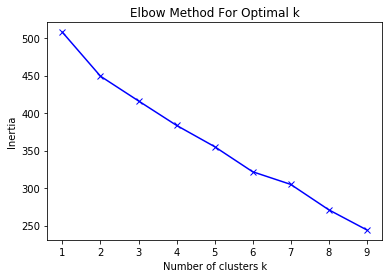

In [52]:
#create temporary data for k 
SGonehotTE = SGonehotT

#use Min Max as scaler option
mms = MinMaxScaler()
mms.fit(SGonehotTE)
data_transformed = mms.transform(SGonehotTE)

Sum_of_squared_distances = []
K = range(1,10)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(data_transformed)
    Sum_of_squared_distances.append(km.inertia_)

#plot chart for optimal k    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('Number of clusters k')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()    

In [43]:
SGonehotTE

,Postal District,Accessories Store,Airport,Airport Service,Airport Terminal,American Restaurant,Aquarium,Arcade,Art Gallery,Art Museum,...,Video Game Store,Vietnamese Restaurant,Water Park,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Yoga Studio,Zoo Exhibit
0,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.01,0.01,...,0.00,0.01,0.00,0.050000,0.00,0.020000,0.00,0.00,0.00,0.000000
1,2,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.01,0.00,...,0.00,0.01,0.00,0.010000,0.00,0.020000,0.00,0.00,0.02,0.000000
2,3,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.000000,0.00,0.010638,0.00,0.00,0.00,0.000000
3,4,0.000000,0.000000,0.000000,0.000000,0.010000,0.01,0.01,0.01,0.00,...,0.00,0.01,0.01,0.010000,0.00,0.000000,0.00,0.00,0.00,0.000000
4,5,0.000000,0.000000,0.000000,0.000000,0.010000,0.00,0.00,0.02,0.00,...,0.00,0.02,0.00,0.000000,0.00,0.000000,0.00,0.00,0.00,0.000000
5,6,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.02,0.01,...,0.00,0.01,0.00,0.050000,0.01,0.020000,0.00,0.00,0.00,0.000000
6,7,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.02,0.00,...,0.00,0.02,0.00,0.020000,0.02,0.000000,0.00,0.00,0.01,0.000000
7,8,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.01,0.01,...,0.00,0.02,0.00,0.000000,0.02,0.010000,0.00,0.00,0.02,0.000000
8,9,0.000000,0.000000,0.000000,0.000000,0.020000,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.000000,0.00,0.000000,0.00,0.00,0.01,0.000000
9,10,0.000000,0.000000,0.000000,0.000000,0.020000,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.000000,0.00,0.000000,0.00,0.00,0.01,0.000000


# Cluster data

In [27]:
#set number of clusters
kclusters = 6

SGonehotT_clustering = SGonehotT.drop('Postal District', 1)

#run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(SGonehotT_clustering)

#add clustering labels
SGpostDvenues.insert(0, 'Cluster Labels', kmeans.labels_)

In [28]:
SGpostDvenues

,Cluster Labels,Postal District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,3,1,Hotel,Waterfront,Italian Restaurant,Bar,Event Space,Cocktail Bar,Coffee Shop,Seafood Restaurant,Wine Bar,Concert Hall
1,3,2,Hotel,Japanese Restaurant,Coffee Shop,Café,Korean Restaurant,Bar,Ramen Restaurant,Spanish Restaurant,Yoga Studio,Beer Garden
2,2,3,Café,Chinese Restaurant,Coffee Shop,Park,Food Court,Indian Restaurant,Seafood Restaurant,Asian Restaurant,Ice Cream Shop,Korean Restaurant
3,2,4,Café,Chinese Restaurant,Scenic Lookout,Trail,Beach,Park,Food Court,Candy Store,Pool,Asian Restaurant
4,5,5,Chinese Restaurant,Coffee Shop,Food Court,Café,Indian Restaurant,Thai Restaurant,Bakery,Seafood Restaurant,Asian Restaurant,Scenic Lookout
5,3,6,Hotel,Japanese Restaurant,Waterfront,Restaurant,Coffee Shop,Event Space,Park,Plaza,French Restaurant,Cocktail Bar
6,3,7,Hotel,Café,Restaurant,Japanese Restaurant,Italian Restaurant,Event Space,Coffee Shop,Movie Theater,French Restaurant,Shopping Mall
7,3,8,Hotel,Indian Restaurant,Café,Chinese Restaurant,Restaurant,Ice Cream Shop,Italian Restaurant,Dessert Shop,Indonesian Restaurant,Whisky Bar
8,1,9,Hotel,Boutique,Japanese Restaurant,Shopping Mall,Coffee Shop,Bakery,Sushi Restaurant,Bubble Tea Shop,Cosmetics Shop,Chinese Restaurant
9,1,10,Hotel,Boutique,Japanese Restaurant,Chinese Restaurant,Sushi Restaurant,Bakery,Coffee Shop,Shopping Mall,Cosmetics Shop,Bubble Tea Shop


In [29]:
#create dataset for comparison merging
SG_merged = SGpost

#merge data to add latitude/longitude for each neighborhood
SG_merged = SG_merged.join(SGpostDvenues.set_index('Postal District'), on='Postal District')

#cast Cluster labels to integers
SG_merged['Cluster Labels'] = SG_merged['Cluster Labels'].fillna(0).astype(np.int64)

#drop Postal District 24 from dataset
SG_merged = SG_merged.drop([24])

In [30]:
SG_merged

,Postal District,General Location,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,1,Raffles Place,1.284408,103.851390,3,Hotel,Waterfront,Italian Restaurant,Bar,Event Space,Cocktail Bar,Coffee Shop,Seafood Restaurant,Wine Bar,Concert Hall
2,2,Anson,1.275815,103.846491,3,Hotel,Japanese Restaurant,Coffee Shop,Café,Korean Restaurant,Bar,Ramen Restaurant,Spanish Restaurant,Yoga Studio,Beer Garden
3,3,Queenstown,1.294623,103.806045,2,Café,Chinese Restaurant,Coffee Shop,Park,Food Court,Indian Restaurant,Seafood Restaurant,Asian Restaurant,Ice Cream Shop,Korean Restaurant
4,4,Telok Blangah,1.270586,103.809863,2,Café,Chinese Restaurant,Scenic Lookout,Trail,Beach,Park,Food Court,Candy Store,Pool,Asian Restaurant
5,5,Pasir Panjang,1.276201,103.791476,5,Chinese Restaurant,Coffee Shop,Food Court,Café,Indian Restaurant,Thai Restaurant,Bakery,Seafood Restaurant,Asian Restaurant,Scenic Lookout
6,6,High Street,1.290125,103.850106,3,Hotel,Japanese Restaurant,Waterfront,Restaurant,Coffee Shop,Event Space,Park,Plaza,French Restaurant,Cocktail Bar
7,7,Middle Road,1.298840,103.853757,3,Hotel,Café,Restaurant,Japanese Restaurant,Italian Restaurant,Event Space,Coffee Shop,Movie Theater,French Restaurant,Shopping Mall
8,8,Little India,1.307457,103.852572,3,Hotel,Indian Restaurant,Café,Chinese Restaurant,Restaurant,Ice Cream Shop,Italian Restaurant,Dessert Shop,Indonesian Restaurant,Whisky Bar
9,9,Orchard,1.305272,103.832876,1,Hotel,Boutique,Japanese Restaurant,Shopping Mall,Coffee Shop,Bakery,Sushi Restaurant,Bubble Tea Shop,Cosmetics Shop,Chinese Restaurant
10,10,Ardmore,1.308830,103.830130,1,Hotel,Boutique,Japanese Restaurant,Chinese Restaurant,Sushi Restaurant,Bakery,Coffee Shop,Shopping Mall,Cosmetics Shop,Bubble Tea Shop


# Map of clusters

In [31]:
#create map of clusters
map_clusters = folium.Map(location=[sglatitude, sglongitude], zoom_start=12)

#set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

#add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(SG_merged['Latitude'], SG_merged['Longitude'], SG_merged['Postal District'], SG_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster Labels ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=7,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=1).add_to(map_clusters)
       
map_clusters

# Analysis

In [32]:
#Cluster 0
SG_merged.loc[SG_merged['Cluster Labels'] == 0, SG_merged.columns[[1] + list(range(5,SG_merged.shape[1]))]]

,General Location,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
13,Macpherson,Food Court,Chinese Restaurant,Asian Restaurant,Seafood Restaurant,Vegetarian / Vegan Restaurant,BBQ Joint,Snack Place,Noodle House,Café,Coffee Shop
14,Geylang,Chinese Restaurant,Asian Restaurant,Food Court,Seafood Restaurant,BBQ Joint,Noodle House,Vegetarian / Vegan Restaurant,Dim Sum Restaurant,Café,Vietnamese Restaurant
15,Katong,Chinese Restaurant,Hotel,Coffee Shop,Vietnamese Restaurant,Seafood Restaurant,Japanese Restaurant,BBQ Joint,Asian Restaurant,Noodle House,Multiplex


In [33]:
#Cluster 1
SG_merged.loc[SG_merged['Cluster Labels'] == 1, SG_merged.columns[[1] + list(range(5,SG_merged.shape[1]))]]

,General Location,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
9,Orchard,Hotel,Boutique,Japanese Restaurant,Shopping Mall,Coffee Shop,Bakery,Sushi Restaurant,Bubble Tea Shop,Cosmetics Shop,Chinese Restaurant
10,Ardmore,Hotel,Boutique,Japanese Restaurant,Chinese Restaurant,Sushi Restaurant,Bakery,Coffee Shop,Shopping Mall,Cosmetics Shop,Bubble Tea Shop


In [34]:
#Cluster 2
SG_merged.loc[SG_merged['Cluster Labels'] == 2, SG_merged.columns[[1] + list(range(5,SG_merged.shape[1]))]]

,General Location,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Queenstown,Café,Chinese Restaurant,Coffee Shop,Park,Food Court,Indian Restaurant,Seafood Restaurant,Asian Restaurant,Ice Cream Shop,Korean Restaurant
4,Telok Blangah,Café,Chinese Restaurant,Scenic Lookout,Trail,Beach,Park,Food Court,Candy Store,Pool,Asian Restaurant
17,Loyang,Resort,Café,Asian Restaurant,Indian Restaurant,Bus Station,Waterfront,Restaurant,Coffee Shop,Grocery Store,Thai Restaurant
23,Hillview,Food Court,Trail,Fast Food Restaurant,Coffee Shop,Park,Nature Preserve,Italian Restaurant,Café,Sandwich Place,Shopping Mall
25,Kranji,Asian Restaurant,Grocery Store,Food Court,Trail,Department Store,Bar,Park,Hainan Restaurant,Bowling Alley,Go Kart Track
28,Seletar,Café,Airport,Food Court,Bus Stop,Pizza Place,Park,Restaurant,Noodle House,Bistro,Other Repair Shop


In [35]:
#Cluster 3
SG_merged.loc[SG_merged['Cluster Labels'] == 3, SG_merged.columns[[1] + list(range(5,SG_merged.shape[1]))]]

,General Location,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Raffles Place,Hotel,Waterfront,Italian Restaurant,Bar,Event Space,Cocktail Bar,Coffee Shop,Seafood Restaurant,Wine Bar,Concert Hall
2,Anson,Hotel,Japanese Restaurant,Coffee Shop,Café,Korean Restaurant,Bar,Ramen Restaurant,Spanish Restaurant,Yoga Studio,Beer Garden
6,High Street,Hotel,Japanese Restaurant,Waterfront,Restaurant,Coffee Shop,Event Space,Park,Plaza,French Restaurant,Cocktail Bar
7,Middle Road,Hotel,Café,Restaurant,Japanese Restaurant,Italian Restaurant,Event Space,Coffee Shop,Movie Theater,French Restaurant,Shopping Mall
8,Little India,Hotel,Indian Restaurant,Café,Chinese Restaurant,Restaurant,Ice Cream Shop,Italian Restaurant,Dessert Shop,Indonesian Restaurant,Whisky Bar
12,Balestier,Chinese Restaurant,Hotel,Bakery,Café,Dessert Shop,Food Court,Indian Restaurant,Coffee Shop,Ramen Restaurant,Supermarket


In [36]:
#Cluster 4
SG_merged.loc[SG_merged['Cluster Labels'] == 4, SG_merged.columns[[1] + list(range(5,SG_merged.shape[1]))]]

,General Location,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
11,Watten Estate,Bakery,Italian Restaurant,Japanese Restaurant,Café,Chinese Restaurant,Food Court,French Restaurant,Restaurant,Seafood Restaurant,Thai Restaurant
21,Upper Bukit Timah,Café,Italian Restaurant,Chinese Restaurant,Bakery,Pizza Place,Supermarket,Thai Restaurant,Restaurant,Soccer Field,Japanese Restaurant
26,Upper Thomson,Chinese Restaurant,Indian Restaurant,Golf Course,Café,Convenience Store,Supermarket,Gym,Lake,Thai Restaurant,Park


In [37]:
#Cluster 5
SG_merged.loc[SG_merged['Cluster Labels'] == 5, SG_merged.columns[[1] + list(range(5,SG_merged.shape[1]))]]

,General Location,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,Pasir Panjang,Chinese Restaurant,Coffee Shop,Food Court,Café,Indian Restaurant,Thai Restaurant,Bakery,Seafood Restaurant,Asian Restaurant,Scenic Lookout
16,Bedok,Chinese Restaurant,Coffee Shop,Food Court,Asian Restaurant,Seafood Restaurant,Noodle House,Fast Food Restaurant,Japanese Restaurant,Supermarket,Bakery
18,Tampines,Coffee Shop,Café,Dessert Shop,Fast Food Restaurant,Asian Restaurant,Noodle House,Food Court,Chinese Restaurant,Japanese Restaurant,Bakery
19,Serangoon Garden,Coffee Shop,Chinese Restaurant,Asian Restaurant,Noodle House,Food Court,Ice Cream Shop,Bakery,Dessert Shop,Café,Korean Restaurant
20,Bishan,Coffee Shop,Chinese Restaurant,Food Court,Ice Cream Shop,Seafood Restaurant,Bakery,Thai Restaurant,Asian Restaurant,Japanese Restaurant,BBQ Joint
22,Jurong,Chinese Restaurant,Coffee Shop,Food Court,Japanese Restaurant,Playground,Supermarket,Bar,Garden,Bubble Tea Shop,Vegetarian / Vegan Restaurant
27,Yishun,Coffee Shop,Chinese Restaurant,Asian Restaurant,Thai Restaurant,Indian Restaurant,Food Court,Park,Sushi Restaurant,Fried Chicken Joint,American Restaurant
